In [4]:
import os
os.environ["CDF_LIB"] = 'c:\cdf_distribution\cdf38_0-dist'
#import spacepy.toolbox
#spacepy.toolbox.update(leapsecs=True)
from spacepy import pycdf
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import scipy.io

import SEMP

C:\Users\Pjer1\anaconda3\lib\site-packages\spacepy\time.py:2365: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


In [63]:
def open_dyspec_npz(fname):
    with np.load(fname,allow_pickle=True) as data:
        freq_arr = data['freq_arr']
        t_arr = data['t_arr']
        dyspec = data['dyspec']
    return freq_arr,t_arr,dyspec

In [64]:
dt_anchor = datetime.datetime(2020,7,21,2,0,0)
anchor_time = mdates.date2num(dt_anchor)

In [65]:
# for WIND STEREO
mat = scipy.io.loadmat('tmpData/20200721/20200721.mat')

In [66]:
t1=mat['mdata'][0][0][19].ravel()
t2=mat['mdata'][0][0][20].ravel()
f_ST_A=mat['mdata'][0][0][30].ravel()/1e3
f_WIND=mat['mdata'][0][0][31].ravel()/1e3
t_ST_A=mat['mdata'][0][0][42].ravel()
t_WIND=mat['mdata'][0][0][43].ravel()

In [67]:
t_diff = (mdates.date2num(pd.to_datetime(t1.ravel()-719529, unit='D'))-anchor_time)*24*60
print(pd.to_datetime(t1.ravel()-719529, unit='D')) # ref in STE and WIND)

DatetimeIndex(['2020-07-21 02:21:46.602180096'], dtype='datetime64[ns]', freq=None)


In [68]:
t_ST_A_offset = t_ST_A+ t_diff
t_WIND_offset = t_WIND+ t_diff

In [69]:
# load solution
sol_ready = True

f = np.load('solution.npz')
f_model =f['f_model'] /1e6
t_model_STA =f['t_model_STA']/60
t_model_WI =f['t_model_WI'] /60
t_model_PSP =f['t_model_PSP'] /60
t_model_SOLO =f['t_model_SOLO'] /60

In [70]:
t_model_PSP

array([129.99218391, 112.92921728, 100.23667656,  90.5921152 ,
        83.12585218,  77.2550302 ,  72.58129187,  68.82592135,
        65.78859833,  63.32128826,  61.31174205,  59.67299167,
        58.33653579,  57.24778213,  56.362865  ,  55.64628423,
        55.06900245,  54.60678882,  54.23880424,  53.94665473,
        53.71412555,  53.5274202 ,  53.37540906,  53.24955232,
        53.14352281,  53.05271656,  52.97379792,  52.90433774,
        52.84254743,  52.78709109])

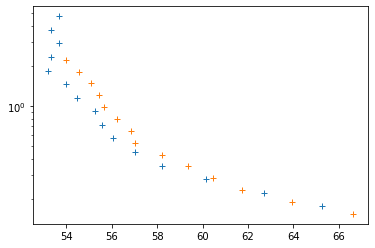

In [71]:
plt.plot(t_ST_A_offset,f_ST_A,'+')
plt.plot(t_WIND_offset,f_WIND,'+')
plt.yscale('log')

In [72]:
fnamePSPHFR = 'tmpData/20200721/DATA_2020_07_21_PSPHFR.npz'
fnamePSPLFR = 'tmpData/20200721/DATA_2020_07_21_PSPLFR.npz'
fnameSTE_A = 'tmpDATA/20200721/DATA_2020_07_21_STEREOA.npz'

In [73]:
freq_arrHFR,t_arrHFR,dyspecHFR = open_dyspec_npz(fnamePSPHFR)
freq_arrLFR,t_arrLFR,dyspecLFR = open_dyspec_npz(fnamePSPLFR)
t_arrHFR = np.array([t.datetime64 for t in t_arrHFR.ravel()])
t_arrLFR = np.array([t.datetime64 for t in t_arrLFR.ravel()])

In [74]:
tidx = np.arange(t_arrHFR.shape[0])

In [75]:
t_offsetPSP = (mdates.date2num(t_arrHFR)-anchor_time)*24*60
dyspecPSP = np.concatenate([dyspecLFR[0:-1,0:-1],dyspecHFR[0:-1,0:-1]],0)
freq_PSP = np.concatenate([freq_arrLFR,freq_arrHFR])

In [76]:
f_selectPSP = np.uint(np.linspace(21,95,18))
t_range_idx = np.arange(t_offsetPSP.shape[0])[(t_offsetPSP>20) & (t_offsetPSP<90)]

In [77]:

leading_edge_PSP = np.zeros(f_selectPSP.shape)
for i_n,idx in enumerate(f_selectPSP) :
    freq_this =  freq_PSP[idx]
    arr_this = dyspecPSP[idx,t_range_idx]
    leading_edge_PSP[i_n] = SEMP.findLeadingPoint(t_offsetPSP[t_range_idx],arr_this,ratio_x=0.9,thresh_std = 5)

C:\Users\Pjer1\AppData\Local\Temp\ipykernel_71148\2815373683.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_offsetPSP,freq_PSP,np.log(dyspecPSP),cmap='inferno')


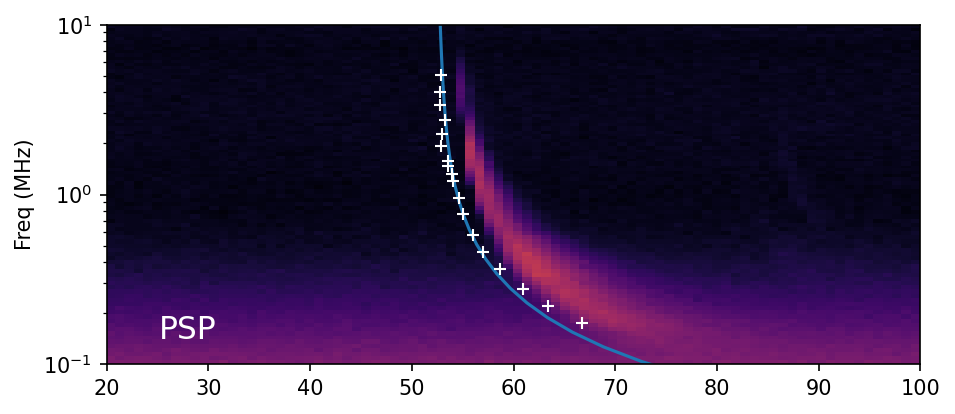

In [78]:
plt.figure(figsize=[7,3],dpi=150)
plt.ylabel('Freq (MHz)')
plt.pcolormesh(t_offsetPSP,freq_PSP,np.log(dyspecPSP),cmap='inferno')
plt.yscale('log')
plt.xlim([20,100])
plt.ylim([0.1,10])

plt.plot(leading_edge_PSP,(freq_PSP[f_selectPSP]),'w+',zorder=100)
if sol_ready:
    plt.plot(t_model_PSP,f_model)

plt.text(0.1, 0.1,'PSP',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = plt.gca().transAxes,
     fontsize=15)

plt.gcf().savefig('20200721/1.jpg',bbox_inches='tight',pad_inches=0)

In [79]:
freq_arrSTA,t_arrSTA,dyspecSTA = open_dyspec_npz(fnameSTE_A)
t_arrSTA = np.array([t.datetime64 for t in t_arrSTA.ravel()])
t_offsetSTA = (mdates.date2num(t_arrSTA)-anchor_time)*24*60
dyspecSTA=dyspecSTA[0:-1,0:-1]

C:\Users\Pjer1\AppData\Local\Temp\ipykernel_71148\3477623790.py:3: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(t_offsetSTA,freq_arrSTA,np.log(dyspecSTA),cmap='inferno')
C:\Users\Pjer1\AppData\Local\Temp\ipykernel_71148\3477623790.py:3: RuntimeWarning: invalid value encountered in log
  plt.pcolormesh(t_offsetSTA,freq_arrSTA,np.log(dyspecSTA),cmap='inferno')
C:\Users\Pjer1\AppData\Local\Temp\ipykernel_71148\3477623790.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_offsetSTA,freq_arrSTA,np.log(dyspecSTA),cmap='inferno')


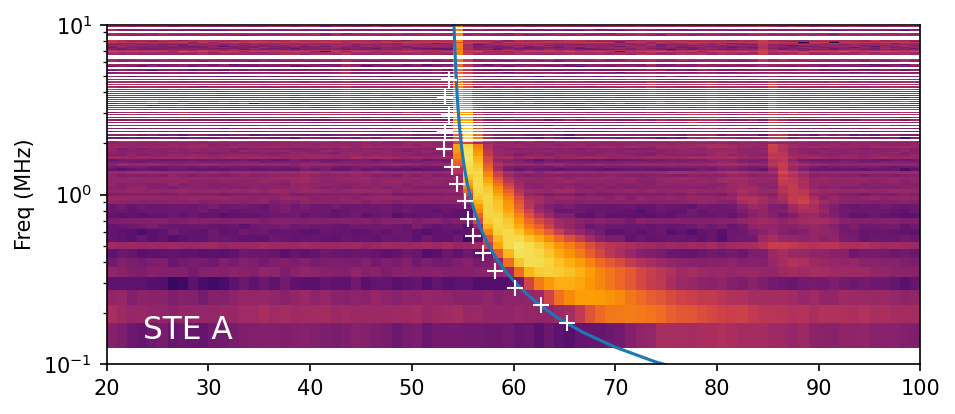

In [80]:
plt.figure(figsize=[7,3],dpi=150)
plt.ylabel('Freq (MHz)')
plt.pcolormesh(t_offsetSTA,freq_arrSTA,np.log(dyspecSTA),cmap='inferno')
plt.yscale('log')
plt.xlim([20,100])
plt.plot(t_ST_A_offset,f_ST_A,'w+',ms=8,zorder=100)
if sol_ready:
    plt.plot(t_model_STA,f_model)
    
plt.ylim([0.1,10])

plt.text(0.1, 0.1,'STE A',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = plt.gca().transAxes,
     fontsize=15)

plt.gcf().savefig('20200721/2.jpg',bbox_inches='tight',pad_inches=0)

In [81]:
fnameWIHFR = 'tmpData/20200721/DATA_2020_07_21_WINDRAD1.npz'
fnameWILFR = 'tmpData/20200721/DATA_2020_07_21_WINDRAD2.npz'

freq_arrWI1,t_arrWI1,dyspecWI1 = open_dyspec_npz(fnameWIHFR)
freq_arrWI2,t_arrWI2,dyspecWI2 = open_dyspec_npz(fnameWILFR)
t_arrWI1 = np.array([t.datetime64 for t in t_arrWI1.ravel()])
t_arrWI2 = np.array([t.datetime64 for t in t_arrWI2.ravel()])

dyspecWI = np.concatenate([dyspecWI1[0:-1,0:-1],dyspecWI2[0:-1,0:-1]],0)
freq_WI = np.concatenate([freq_arrWI1,freq_arrWI2])

In [82]:
t_arrWI1_offset = (mdates.date2num(t_arrWI1)-anchor_time)*24*60

C:\Users\Pjer1\AppData\Local\Temp\ipykernel_71148\3898408463.py:3: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(t_arrWI1_offset,freq_WI,np.log(dyspecWI),cmap='inferno')
C:\Users\Pjer1\AppData\Local\Temp\ipykernel_71148\3898408463.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_arrWI1_offset,freq_WI,np.log(dyspecWI),cmap='inferno')


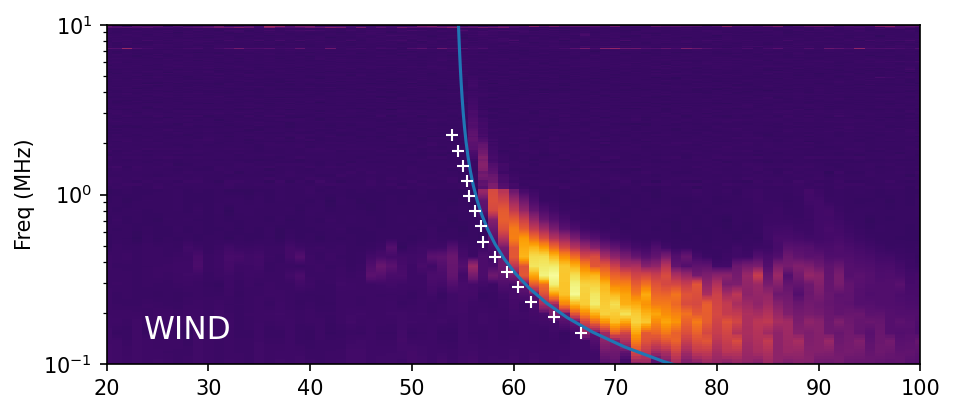

In [83]:
plt.figure(figsize=[7,3],dpi=150)
plt.ylabel('Freq (MHz)')
plt.pcolormesh(t_arrWI1_offset,freq_WI,np.log(dyspecWI),cmap='inferno')
plt.yscale('log')
plt.xlim([20,100])

plt.plot(t_WIND_offset,f_WIND,'w+',zorder=100)
if sol_ready:
    plt.plot(t_model_WI,f_model)
plt.ylim([0.1,10])

plt.text(0.1, 0.1,'WIND',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = plt.gca().transAxes,
     fontsize=15)


plt.gcf().savefig('20200721/3.jpg',bbox_inches='tight',pad_inches=0)

In [84]:
fnameSOLO='tmpData/20200721/DATA_2020_07_21_SOLO.npz'

In [85]:

freq_arrSOLO,t_arrSOLO,dyspecSOLO = open_dyspec_npz(fnameSOLO)

t_arrSOLO = np.array([t.datetime64 for t in t_arrSOLO.ravel()])
t_offsetSOLO = (mdates.date2num(t_arrSOLO)-anchor_time)*24*60
dyspecSOLO=dyspecSOLO[0:-1,0:-1]
f_selectSOLO = np.uint(np.logspace(np.log10(1),np.log10(100),20))

In [86]:
t_range_idx = np.arange(t_offsetSOLO.shape[0])[(t_offsetSOLO>20) & (t_offsetSOLO<90)]
leading_edge_SOLO = np.zeros(f_selectSOLO.shape)
for i_n,idx in enumerate(f_selectSOLO) :
    freq_this =  freq_arrSOLO[idx]
    arr_this = dyspecSOLO[idx,t_range_idx]
    leading_edge_SOLO[i_n] = SEMP.findLeadingPoint(t_offsetSOLO[t_range_idx],arr_this,ratio_x=0.90,thresh_std = 5)

C:\Users\Pjer1\AppData\Local\Temp\ipykernel_71148\437020650.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_offsetSOLO,freq_arrSOLO,(dyspecSOLO),cmap='inferno',


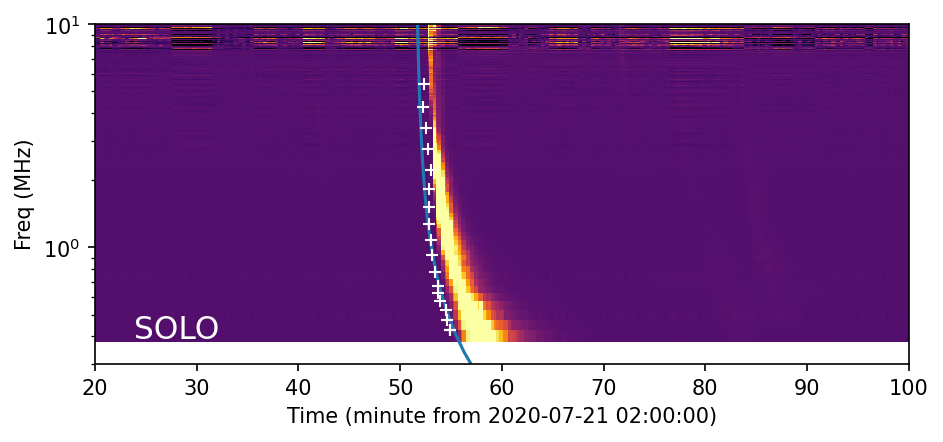

In [87]:
plt.figure(figsize=[7,3],dpi=150)
plt.ylabel('Freq (MHz)')
plt.xlabel('Time (minute from '+str(dt_anchor)+')')
dyspecWI = np.concatenate([dyspecWI1[0:-1,0:-1],dyspecWI2[0:-1,0:-1]],0)
freq_WI = np.concatenate([freq_arrWI1,freq_arrWI2])
plt.pcolormesh(t_offsetSOLO,freq_arrSOLO,(dyspecSOLO),cmap='inferno',
               vmin=np.mean(dyspecSOLO)-1*np.std(dyspecSOLO),
              vmax=np.mean(dyspecSOLO)+3*np.std(dyspecSOLO))
plt.yscale('log')
plt.xlim([20,100])
plt.ylim([0.3,10])
plt.plot(leading_edge_SOLO,freq_arrSOLO[f_selectSOLO],'w+',zorder=100)
if sol_ready:
    plt.plot(t_model_SOLO,f_model)

plt.text(0.1, 0.1,'SOLO',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = plt.gca().transAxes,
     fontsize=15)

plt.gcf().savefig('20200721/4.jpg',bbox_inches='tight',pad_inches=0)

In [88]:
#summary

np.savez('offset.npz',t_ST_A_offset=t_ST_A_offset,f_ST_A=f_ST_A,
                    t_WIND_offset=t_WIND_offset,f_WIND=f_WIND,
                   t_PSP_offset=leading_edge_PSP,f_PSP=(freq_PSP[f_selectPSP]),
                  t_SOLO_offset= leading_edge_SOLO,f_SOLO=freq_arrSOLO[f_selectSOLO] )



In [89]:
50*60

3000

In [90]:
60*(t_offsetPSP[2]-t_offsetPSP[1])

55.92407336225733